In [0]:
!pip install tensorflow==1.15

모두의 강화학습 [코드](https://hunkim.github.io/ml/)를 참고하였습니다. 

### 1. 라이브러리 임폴트 

In [0]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import collections
%matplotlib inline

### 2. Cart Pole 환경 불러오기 
Open AI Gym 에 준비되어 있는 Cart Pole 환경을 가져옴. 
Cart Pole 게임은 막대기가 떨어지지 않도록 하는 게임이며,  
state로 4개의 실수값이 들어옴.  

In [0]:
env = gym.make('CartPole-v0') 

learning_rate = 1e-1
input_size = env.observation_space.shape[0] #4
output_size = env.action_space.n #2


### 3. Q-Network 모델 정의 

In [0]:
X = tf.placeholder(tf.float32, [None, input_size], name="input_x")

W1 = tf.get_variable("W1", shape=[input_size, output_size], initializer=tf.contrib.layers.xavier_initializer())
Qpred = tf.matmul(X, W1)

Y = tf.placeholder(shape=[None, output_size], dtype=tf.float32)
# 손실함수 정의 
loss = tf.reduce_sum(tf.square(Y-Qpred))

train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

### 4. Q-Network 모델 학습



In [0]:
# 하이퍼파라미터 
num_episodes = 2000
dis = 0.9
rList = []

In [0]:
for i in range(num_episodes):
      e = 1. / ((i/10)+1)
      rAll = 0
      step_count = 0
      s = env.reset()
      done = False

      while not done:
          step_count += 1
          # 상태를 (1,4) 로 변환함.
          x = np.reshape(s, [1, input_size])
          Qs = sess.run(Qpred, feed_dict={X:x})

          # e greedy 알고리즘을 사용하여, 랜덤하게 액션을 선택하거나 Argmax 한 액션을 선택한다. 
          if np.random.rand(1) < e:
              a = env.action_space.sample()
          else:
              a = np.argmax(Qs)
              
          # 액션을 취함.
          s1, reward, done, _ = env.step(a)

          if done:
            # 넘어지기 전에 리워드를 마이너스로 변경함.
            Qs[0, a] = -100
          else:
            x1 = np.reshape(s1, [1, input_size])
            Qs1 = sess.run(Qpred, feed_dict = {X:x1})
            # 현재 받은 리워드와 다음번에 받을 값 
            Qs[0, a] = reward + dis * np.max(Qs1) 
          
          sess.run(train, feed_dict = {X:x, Y:Qs})
          s = s1
      rList.append(step_count)
      print("Episode: {} steps: {}".format(i, step_count))

      if(len(rList) > 0 and np.mean(rList[-10:]) > 500):
        break
      

### 4. Loss Surface 

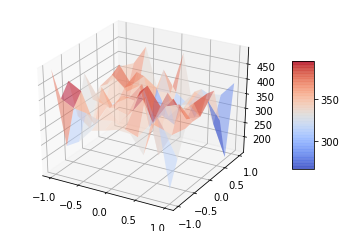

In [9]:
ms = np.linspace(-1.0, 1.0, 10)
bs = np.linspace(-1.0, 1.0, 10)

M, B = np.meshgrid(ms, bs)

zs = []
for alpha, beta in zip(np.ravel(M), np.ravel(B)):
  observation = env.reset()
  loss_avg = 0
  k = 0
  ####
  W_N = W1 + alpha * np.random.randn(4,2) + beta * np.random.randn(4,2)
  Qpred = tf.matmul(X, W_N)

  ####
  while True:
    k+=1
    x = np.reshape(observation, [1, input_size])
  
    Qs = sess.run(Qpred, feed_dict = {X:x1})
    Qs[0, a] = reward + dis * np.max(Qs)
    a = np.argmax(Qs)
    loss_ = sess.run(loss, feed_dict = {X:x, Y:Qs})

    observation, reward, done, _ = env.step(a)
    loss_avg += loss_

    if done:
      # print("Total score : {}".format(loss_avg/k))
      break

  elem = loss_avg/k
  zs.append(elem)


zs = np.array(zs)
# zs = np.array([loss_surface(agent, alpha, beta) for alpha, beta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(M, B, Z, rstride=1, cstride=1, cmap=cm.coolwarm, alpha=0.5)

# ax.set_xlabel('m')
# ax.set_ylabel('b')
# ax.set_zlabel('error')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()